# IBM Data Science Capstone Final Project

### I. Introduction

As part of my final capstone project for IBM Data Science Professional Certificate in Coursera, I choose to explore neighborhoods for Riyadh city, where i'm living,  using Foursquare location data. Riyadh is a metopletanian area with more than 6 million (macrotrends web site) people living there, the tunisian people who immigrate to Saudia arabia and scpecially to Riyadh are in exponential increase and the need to find and enjoy tunisian cuisine is on the rise. Due to the limit number of tunsian restaurant in Riyadh, the idea to find more suitable place to begin such project comes up.

### II. Business Problem

The queston to answer is **"Where is the more suitable place to launch such project?"** in Riyadh, Saudia Arbia. I will try to answer this question by using data science, machine learning method (clustering) and Foresquare Api to extract needed data.


### III. Target Audiance

for any entrepreneur or businessman who wants to find a location to lanch such project

### IV. Data

The data needed for the project is:
- Riyadh location (Latitude and Longitude)
- Neighborhood list in Riyadh city.
- Latitude and Longitude relative to these neihborhoods.
- Venue List of north african restaurant.

#### IV.1 Datasets

1- List of neighborhood from https://en.wikipedia.org/wiki/Riyadh#City_districts

2- Foresquare Api to extract the venue list for each neighborhood</div>

#### IV.2 Extracting the data
- scapping Riyadh neighborhood via Wikipedia
- Get latitude and longitude for each neighborhood extracted in previous section using geocoder
- extract venue list of each neighborhood using foresquare Api

In [127]:
#!pip install folium
#!pip install beautifulsoup4
#!pip install lxml
#!pip install geopy

import pandas as pd
import numpy as np
import seaborn as sns
import requests
from bs4 import BeautifulSoup


from urllib.request import urlopen
import re
from geopy.geocoders import Nominatim

import folium # map rendering library

print('Librairies Imported')

Librairies Imported


#### IV.1.1 Functions Declared to be used later

In [128]:
def replacer(s, newstring, index, nofail=False):
    # raise an error if index is outside of the string
    if not nofail and index not in range(len(s)):
        raise ValueError("index outside given string")

    # if not erroring, but the index is still not in the correct range..
    if index < 0:  # add it to the beginning
        return newstring + s
    if index > len(s):  # add it to the end
        return s + newstring

    # insert the new string between "slices" of the original
    return s[:index] + newstring + s[index + 1:]

def cleanTxt(txt):
    idx_start=txt.find("(")
    idx_end=txt.find(")")
    
    if idx_start <0:
        return txt
    if idx_start <0:
        return txt
    return txt[:idx_start] + txt[idx_end+1:]

fn_repl = lambda a: a.replace("'","")

def getAdressLocation(adress):
    adress=adress + ", Riyadh"
    latitude=0
    longitude=0
    geolocator = Nominatim()
    location = geolocator.geocode(address)
    if location != None:
        latitude = location.latitude
        longitude = location.longitude
    
    return latitude, longitude

def is_restaurant(categories, specific_filter=None):
    restaurant_words=['restaurant','sandwich','breakfast','falafel','burger','pizza','shawarma','steakhouse']
    restaurant = False
    specific = False
    for c in categories:
        category_name = c[0].lower()
        category_id = c[1]
        for r in restaurant_words:
            if r in category_name:
                restaurant = True
        if 'fast food' in category_name:
            restaurant = False
        if not(specific_filter is None) and (category_id in specific_filter):
            specific = True
            restaurant = True
    return restaurant, specific

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

def get_restaurants(lats, lons):
    restaurants = {}
    spec_restaurants = {}
    location_restaurants = []

    print('Obtaining venues around candidate locations:', end='')
    for lat, lon in zip(lats, lons):
        # Using radius=350 to meke sure we have overlaps/full coverage so we don't miss any restaurant (we're using dictionaries to remove any duplicates resulting from area overlaps)
        venues = get_venues_near_location(lat, lon, food_category, foursquare_client_id, foursquare_client_secret, radius=350, limit=100)
        area_restaurants = []
        for venue in venues:
            venue_id = venue[0]
            venue_name = venue[1]
            venue_categories = venue[2]
            venue_latlon = venue[3]
            venue_address = venue[4]
            venue_distance = venue[5]
            is_res, is_spec = is_restaurant(venue_categories, specific_filter=italian_restaurant_categories)
            if is_res:
                x, y = lonlat_to_xy(venue_latlon[1], venue_latlon[0])
                restaurant = (venue_id, venue_name, venue_latlon[0], venue_latlon[1], venue_address, venue_distance, is_spec, x, y)
                if venue_distance<=300:
                    area_restaurants.append(restaurant)
                restaurants[venue_id] = restaurant
                if is_spec:
                    spec_restaurants[venue_id] = restaurant
        location_restaurants.append(area_restaurants)
        print(' .', end='')
    print(' done.')
    return restaurants, spec_restaurants, location_restaurants

#### IV.1.2 Scrapping Riyadh Neighborhood list
Get the list of distict in riyadh city from wikipedia page and save it to pandas DataFrame

In [129]:
html = urlopen("https://en.wikipedia.org/wiki/Riyadh#City_districts").read()
soup = BeautifulSoup(html)
divparent = soup.find_all('div', attrs={'class':'div-col columns column-width'})[0]
ldistr=[]
for row in divparent.find_all('ul'):
    for data in row.find_all('li'):
        if data.string!=None:
            #print(data.string,"--__--" ,cleanTxt(data.string))
            entry=cleanTxt(fn_repl(data.string))
            ldistr.append(entry)

columns=['District']
df_org=pd.DataFrame(ldistr,columns=columns)
df_org.head()


,District
0,Al-Deerah
1,Mikal
2,Manfuha
3,Manfuha Al-Jadidah
4,Al-Oud


#### IV.1.3. Drop duplicates

In [130]:
print("dataset shape before : ",df_org.shape)
# sorting by first name 
df_org.sort_values("District", inplace = True) 
df_org
# dropping ALL duplicte values 
df=df_org.drop_duplicates() 
print("dataset shape after : ",df.shape)


dataset shape before :  (196, 1)
dataset shape after :  (95, 1)


#### IV.1.4. Get AL-Riyadh city coordinate

In [131]:
address = 'Riyadh, SA'
geolocator = Nominatim()
location = geolocator.geocode(address)
ar_lat = location.latitude
ar_long = location.longitude
print('Al-Riyadh center longitude={}, latitude={}'.format(ar_lat, ar_long))

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


Al-Riyadh center longitude=24.6319692, latitude=46.7150648


#### IV.1.5. Get Riyadh Neighborhoods coordinate
we need to get the coordinate of Riyadh neighborhoods in order to get the list of venues

In [341]:
d=[]
for index, row in df.iterrows():
    address = row['District'] + ", Riyadh"
    geolocator = Nominatim()
    location = geolocator.geocode(address)
    if location != None:
        latitude = location.latitude
        longitude = location.longitude
        d.append({'District': row['District'], 'latitude': latitude, 'longitude':longitude})
        
df_new=pd.DataFrame(d)
df_new.head()
df_new.to_csv('Riyadh_Neib_Loc.csv')

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  after removing the cwd from sys.path.


In [132]:
df_loc=pd.read_csv('Riyadh_Neib_Loc.csv',index_col=0)
df_loc=df_loc[['District','latitude','longitude']]
print(df_loc.shape)
df_loc.head()

(71, 3)


,District,latitude,longitude
0,Ad Difa,24.592784,46.833947
1,Al Iskan,21.400517,39.780900
2,Al Izdihar,24.780321,46.717530
3,Al Mansouriyah,24.625390,46.522381
4,Al-Arid,24.499165,47.000378


##### we see that we have 71 district

#### IV.1.6 Get venues list from foresquare API
Now we will extract coordinate of districts extracted previously from wikipedia page. Let's use Foursquare API to get info on restaurants in each neighborhood.
We're interested in venues in restaurants category. So we will include in out list only venues that have 'restaurant' in category name.

In [133]:
CLIENT_ID = 'BOFHLRFQGM3DJZ4LI304HFTRLU3E13ZQUH0ID4YGELEUBH31'
CLIENT_SECRET = '2QI4QX02F0L0KXBRUMKPLUPPPYRUCRHKOQKZ4PLFKMIB31H5'
VERSION = '20200201' # Foursquare API version
LIMIT = 200 # limit of number of venues returned by Foursquare API
radius = 750 # define radius

##### IV.1.6.1 Get Venue List

In [ ]:
Riyadh_venues = getNearbyVenues(names=df_loc['District'],latitudes=df_loc['latitude'], longitudes=df_loc['longitude'])
Riyadh_venues.to_csv("Riyadh_venues.csv")
Riyadh_venues.shape

In [134]:
Riyadh_venues=pd.read_csv("Riyadh_venues.csv")
Riyadh_venues.drop(['Unnamed: 0'], axis = 1,inplace=True)
Riyadh_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Al Iskan,21.400517,39.7809,Dunkin' Donuts (دانكن دوناتس),21.401011,39.780961,Donut Shop
1,Al Iskan,21.400517,39.7809,Baskin-Robbins,21.400857,39.781141,Ice Cream Shop
2,Al Iskan,21.400517,39.7809,مطعم الدومان للكباب الميرو,21.401180,39.780820,Mediterranean Restaurant
3,Al Iskan,21.400517,39.7809,Boga Superfoods (بوقا سوبر فودس),21.399679,39.785251,Sandwich Place
4,Al Iskan,21.400517,39.7809,Little Caesare (ليتل سيزرز),21.400687,39.780630,Pizza Place


##### IV.1.6.2 Filter only retaurant category venues

In [ ]:
Riyadh_restau = Riyadh_venues[Riyadh_venues['Venue Category'].str.contains('Restaurant')]
Riyadh_restau.to_csv("Riyadh_restau.csv")

In [248]:
Riyadh_restau=pd.read_csv("Riyadh_restau.csv")
Riyadh_restau.drop(['Unnamed: 0'], axis = 1,inplace=True)
Riyadh_restau.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Al Iskan,21.400517,39.78090,مطعم الدومان للكباب الميرو,21.401180,39.780820,Mediterranean Restaurant
1,Al Iskan,21.400517,39.78090,Herfy (هرفي),21.400527,39.780757,Fast Food Restaurant
2,Al Iskan,21.400517,39.78090,شاورمتك,21.400806,39.781047,Arepa Restaurant
3,Al Izdihar,24.780321,46.71753,فطائر تركية,24.779479,46.719074,Turkish Restaurant
4,Al Izdihar,24.780321,46.71753,فلافل ابو عدنان,24.778129,46.720055,Falafel Restaurant


##### IV.1.6.3 Exploring the Data

In [136]:
#Number of unique venue categories
print('There are {} uniques categories.'.format(len(Riyadh_restau['Venue Category'].unique())))
#Venue count per Category
print(Riyadh_restau.groupby('Venue Category')['Venue Category'].count().head())

There are 26 uniques categories.
Venue Category
Afghan Restaurant         2
American Restaurant      10
Arepa Restaurant          2
Asian Restaurant          2
Australian Restaurant     1
Name: Venue Category, dtype: int64


##### a. Plot the most frequent restaurant 

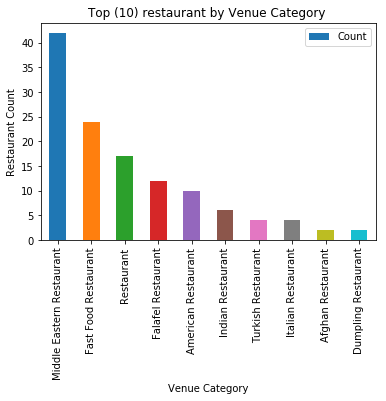

In [137]:
import matplotlib.pyplot as plt

df_byCat=pd.DataFrame({'Count' : Riyadh_restau.groupby( ["Venue Category"]).size()}).reset_index()

df_byCat.sort_values('Count', inplace=True,ascending=False)

df_byCat.head(10).plot(kind='bar',x='Venue Category',y='Count')
plt.title('Top (10) restaurant by Venue Category ')

plt.xlabel('Venue Category')
plt.ylabel('Restaurant Count')

plt.show()

##### b. Plot the most Neighborhood restaurant count

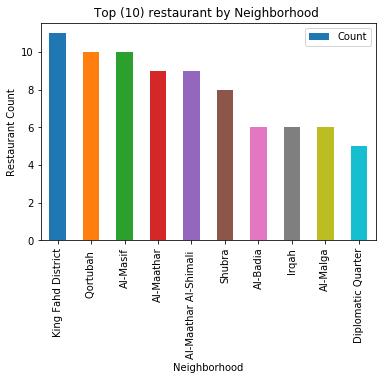

In [138]:
df_byDist=pd.DataFrame({'Count' : Riyadh_restau.groupby( ["Neighborhood"]).size()}).reset_index()
#df_byDist=Riyadh_restau.groupby(["Neighborhood"]).mean().reset_index()
#print(df_byDist.head())
df_byDist.sort_values('Count', inplace=True,ascending=False)

df_byDist.head(10).plot(kind='bar',x='Neighborhood',y='Count')
plt.title('Top (10) restaurant by Neighborhood ')

plt.xlabel('Neighborhood')
plt.ylabel('Restaurant Count')

plt.show()

### V. Methodology <a name="methodology"></a>
Since there no Tunisian restaurant in Riyadh area, we will direct our efforts on detecting districts that have high restaurant density because il will be more frequented.

In first step we have collected the number of restaurant by district.

Second step in our analysis will be calculation and exploration of '**restaurant number**' across different districts - we will use **bar chart** to identify a few promising areas of high number of restaurants and focus our attention on those areas.

In third and final step we will focus on most promising areas and within those create **clusters of locations**. We will present map of all such locations but also create clusters (using **k-means clustering**) of those locations to identify general zones / neighborhoods.

#### VI. Analysis

In [249]:
Riyadh_restau.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Al Iskan,21.400517,39.78090,مطعم الدومان للكباب الميرو,21.401180,39.780820,Mediterranean Restaurant
1,Al Iskan,21.400517,39.78090,Herfy (هرفي),21.400527,39.780757,Fast Food Restaurant
2,Al Iskan,21.400517,39.78090,شاورمتك,21.400806,39.781047,Arepa Restaurant
3,Al Izdihar,24.780321,46.71753,فطائر تركية,24.779479,46.719074,Turkish Restaurant
4,Al Izdihar,24.780321,46.71753,فلافل ابو عدنان,24.778129,46.720055,Falafel Restaurant


In [141]:
# one hot encoding
to_onehot = pd.get_dummies(Riyadh_restau[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = Riyadh_restau['Neighborhood']  
# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]
print(to_onehot.shape)
to_onehot.head()

(141, 27)


,Neighborhoods,Afghan Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Australian Restaurant,Cantonese Restaurant,Chinese Restaurant,Dumpling Restaurant,Dutch Restaurant,...,Japanese Restaurant,Kebab Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Peruvian Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Turkish Restaurant
0,Al Iskan,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,Al Iskan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Al Iskan,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Al Izdihar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Al Izdihar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [142]:
#group by Neighborhoods and get the mean
rr_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index()
print(rr_grouped.shape)
rr_grouped.info()

(43, 27)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 27 columns):
Neighborhoods                43 non-null object
Afghan Restaurant            43 non-null float64
American Restaurant          43 non-null float64
Arepa Restaurant             43 non-null float64
Asian Restaurant             43 non-null float64
Australian Restaurant        43 non-null float64
Cantonese Restaurant         43 non-null float64
Chinese Restaurant           43 non-null float64
Dumpling Restaurant          43 non-null float64
Dutch Restaurant             43 non-null float64
English Restaurant           43 non-null float64
Ethiopian Restaurant         43 non-null float64
Falafel Restaurant           43 non-null float64
Fast Food Restaurant         43 non-null float64
German Restaurant            43 non-null float64
Indian Restaurant            43 non-null float64
Italian Restaurant           43 non-null float64
Japanese Restaurant          43 non-null float64
Kebab R

In [143]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhoods'] = rr_grouped['Neighborhoods']

for ind in np.arange(rr_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(rr_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Al Iskan,Fast Food Restaurant,Arepa Restaurant,Mediterranean Restaurant,Falafel Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,Cantonese Restaurant,Chinese Restaurant,Dumpling Restaurant
1,Al Izdihar,Turkish Restaurant,Restaurant,Falafel Restaurant,Fast Food Restaurant,Peruvian Restaurant,Middle Eastern Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Australian Restaurant
2,Al Mansouriyah,Restaurant,Turkish Restaurant,Falafel Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Australian Restaurant,Cantonese Restaurant,Chinese Restaurant,Dumpling Restaurant
3,Al-Badia,Middle Eastern Restaurant,Restaurant,Chinese Restaurant,Turkish Restaurant,Falafel Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Australian Restaurant,Cantonese Restaurant
4,Al-Deerah,Middle Eastern Restaurant,Turkish Restaurant,Falafel Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Australian Restaurant,Cantonese Restaurant,Chinese Restaurant,Dumpling Restaurant


In [144]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5

rr_clustering = rr_grouped.drop('Neighborhoods', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(rr_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [153]:
rr_merged = Riyadh_restau

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
rr_merged = rr_merged.join(neighborhoods_venues_sorted.set_index('Neighborhoods'), on='Neighborhood')

rr_merged= rr_merged.dropna()
fn_conv = lambda a: int(a)
rr_merged["Cluster Labels"]=rr_merged["Cluster Labels"].apply(fn_conv)
rr_merged.head(10) # check the last columns!

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Al Iskan,21.400517,39.780900,مطعم الدومان للكباب الميرو,21.401180,39.780820,Mediterranean Restaurant,1,Fast Food Restaurant,Arepa Restaurant,Mediterranean Restaurant,Falafel Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,Cantonese Restaurant,Chinese Restaurant,Dumpling Restaurant
1,Al Iskan,21.400517,39.780900,Herfy (هرفي),21.400527,39.780757,Fast Food Restaurant,1,Fast Food Restaurant,Arepa Restaurant,Mediterranean Restaurant,Falafel Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,Cantonese Restaurant,Chinese Restaurant,Dumpling Restaurant
2,Al Iskan,21.400517,39.780900,شاورمتك,21.400806,39.781047,Arepa Restaurant,1,Fast Food Restaurant,Arepa Restaurant,Mediterranean Restaurant,Falafel Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,Cantonese Restaurant,Chinese Restaurant,Dumpling Restaurant
3,Al Izdihar,24.780321,46.717530,فطائر تركية,24.779479,46.719074,Turkish Restaurant,1,Turkish Restaurant,Restaurant,Falafel Restaurant,Fast Food Restaurant,Peruvian Restaurant,Middle Eastern Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Australian Restaurant
4,Al Izdihar,24.780321,46.717530,فلافل ابو عدنان,24.778129,46.720055,Falafel Restaurant,1,Turkish Restaurant,Restaurant,Falafel Restaurant,Fast Food Restaurant,Peruvian Restaurant,Middle Eastern Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Australian Restaurant
5,Al Izdihar,24.780321,46.717530,فروج الراية,24.779839,46.719020,Restaurant,1,Turkish Restaurant,Restaurant,Falafel Restaurant,Fast Food Restaurant,Peruvian Restaurant,Middle Eastern Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Australian Restaurant
6,Al Izdihar,24.780321,46.717530,تسالي صحوح,24.777475,46.720629,Fast Food Restaurant,1,Turkish Restaurant,Restaurant,Falafel Restaurant,Fast Food Restaurant,Peruvian Restaurant,Middle Eastern Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Australian Restaurant
7,Al Mansouriyah,24.625390,46.522381,البوفيه اللي عندها تشباتي,24.626924,46.520595,Restaurant,2,Restaurant,Turkish Restaurant,Falafel Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Australian Restaurant,Cantonese Restaurant,Chinese Restaurant,Dumpling Restaurant
8,Al-Badia,24.698285,46.666186,Najdi Village (القرية النجدية),24.697854,46.669565,Middle Eastern Restaurant,0,Middle Eastern Restaurant,Restaurant,Chinese Restaurant,Turkish Restaurant,Falafel Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Australian Restaurant,Cantonese Restaurant
9,Al-Badia,24.698285,46.666186,ركن المذاق,24.698676,46.669012,Middle Eastern Restaurant,0,Middle Eastern Restaurant,Restaurant,Chinese Restaurant,Turkish Restaurant,Falafel Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Australian Restaurant,Cantonese Restaurant


In [154]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[ar_lat, ar_long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(rr_merged['Venue Latitude'], rr_merged['Venue Longitude'], rr_merged['Neighborhood'], rr_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Category by cluster

In [155]:
rr_merged.groupby('Cluster Labels')["Neighborhood"].count()

Cluster Labels
0    46
1    79
2     9
3     5
4     2
Name: Neighborhood, dtype: int64

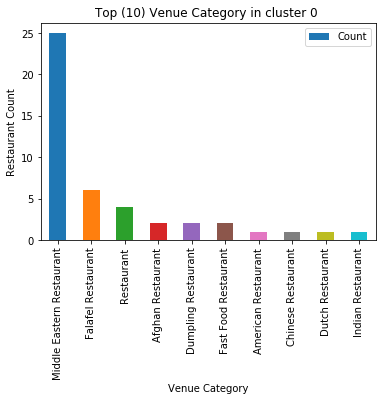

In [160]:
#plt.style.use('ggplot')
mask0=rr_merged['Cluster Labels']==0
df_byLab0=pd.DataFrame({'Count' : rr_merged[mask0].groupby( ["Venue Category"]).size()}).reset_index()

df_byLab0.sort_values('Count', inplace=True,ascending=False)

df_byLab0.head(10).plot(kind='bar',x='Venue Category',y='Count')
plt.title('Top (10) Venue Category in cluster 0 ')

plt.xlabel('Venue Category')
plt.ylabel('Restaurant Count')

plt.show()

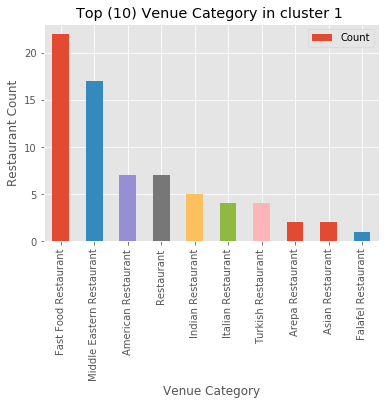

In [228]:
mask1=rr_merged['Cluster Labels']==1
df_byLab1=pd.DataFrame({'Count' : rr_merged[mask1].groupby( ["Venue Category"]).size()}).reset_index()

df_byLab1.sort_values('Count', inplace=True,ascending=False)

df_byLab1.head(10).plot(kind='bar',x='Venue Category',y='Count')
plt.title('Top (10) Venue Category in cluster 1 ')

plt.xlabel('Venue Category')
plt.ylabel('Restaurant Count')

plt.show()

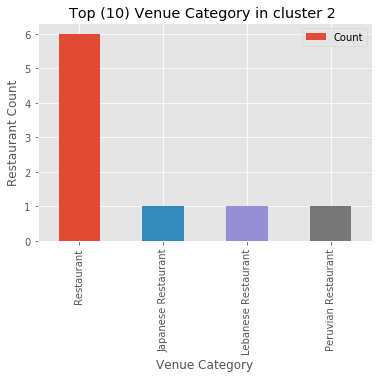

In [238]:
mask2=rr_merged['Cluster Labels']==2
df_byLab2=pd.DataFrame({'Count' : rr_merged[mask2].groupby( ["Venue Category"]).size()}).reset_index()

df_byLab2.sort_values('Count', inplace=True,ascending=False)

df_byLab2.head(10).plot(kind='bar',x='Venue Category',y='Count')
plt.title('Top (10) Venue Category in cluster 2 ')

plt.xlabel('Venue Category')
plt.ylabel('Restaurant Count')

plt.show()

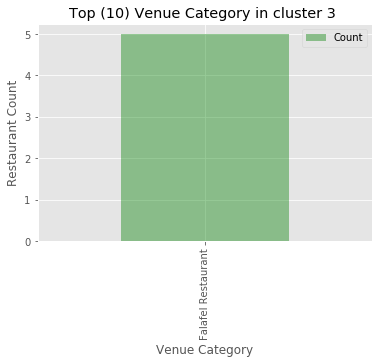

In [231]:
mask3=rr_merged['Cluster Labels']==3
df_byLab3=pd.DataFrame({'Count' : rr_merged[mask3].groupby( ["Venue Category"]).size()}).reset_index()

df_byLab3.sort_values('Count', inplace=True,ascending=False)

df_byLab3.head(10).plot(kind='bar',x='Venue Category',y='Count',color='green',alpha=0.4)
plt.title('Top (10) Venue Category in cluster 3 ')

plt.xlabel('Venue Category')
plt.ylabel('Restaurant Count')

plt.show()

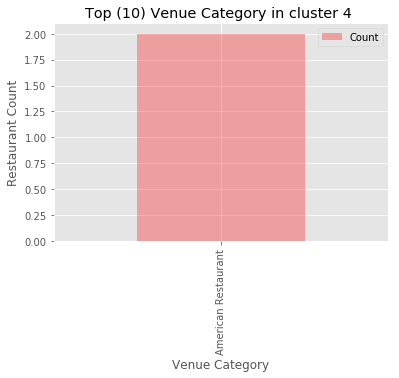

In [234]:
mask4=rr_merged['Cluster Labels']==4
df_byLab4=pd.DataFrame({'Count' : rr_merged[mask4].groupby( ["Venue Category"]).size()}).reset_index()

df_byLab4.sort_values('Count', inplace=True,ascending=False)

df_byLab4.head(10).plot(kind='bar',x='Venue Category',y='Count',color='red',alpha=0.3)
plt.title('Top (10) Venue Category in cluster 4 ')

plt.xlabel('Venue Category')
plt.ylabel('Restaurant Count')

plt.show()

### VII. Results

We decided earlier to choose the district we most frequent retaurants, we can after clustering that cluster 0 and cluster 1 have the biggest number of restaurant.
- **Cluster 0:** "Middle Eastern Restaurant" is the most frequent restaurant.
- **Cluster 1:** "International Restaurant".

let's see in each cluster may District most suitable for each category of restaurant.


#### VII.1 Top 5 District in Cluster 0

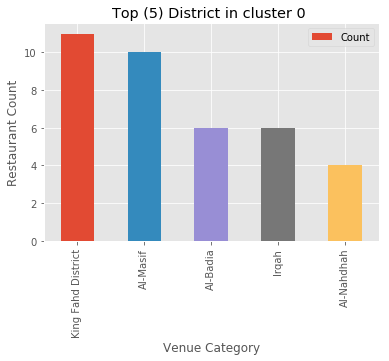

In [243]:
mask0=rr_merged['Cluster Labels']==0
df_byLab0=pd.DataFrame({'Count' : rr_merged[mask0].groupby( ["Neighborhood"]).size()}).reset_index()

df_byLab0.sort_values('Count', inplace=True,ascending=False)
df_byLab0.head(5).plot(kind='bar',x='Neighborhood',y='Count')
plt.title('Top (5) District in cluster 0 ')

plt.xlabel('Venue Category')
plt.ylabel('Restaurant Count')

plt.show()

#### VII.2 Top 5 District in Cluster 1

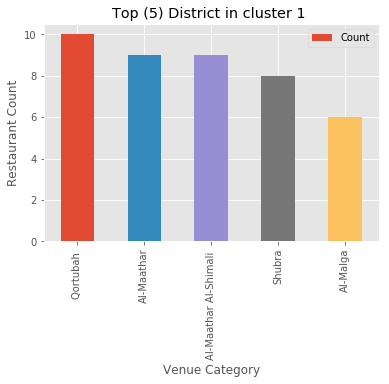

In [244]:
mask1=rr_merged['Cluster Labels']==1
df_byLab1=pd.DataFrame({'Count' : rr_merged[mask1].groupby( ["Neighborhood"]).size()}).reset_index()

df_byLab1.sort_values('Count', inplace=True,ascending=False)

df_byLab1.head(5).plot(kind='bar',x='Neighborhood',y='Count')
plt.title('Top (5) District in cluster 1 ')

plt.xlabel('Venue Category')
plt.ylabel('Restaurant Count')

plt.show()

### VIII. Discussion

According to this analysis, "King fahd District" area will provide most suitable for an upcoming popular restaurant while "Qurtubah" could potentially be a target for starting quality restaurants.

The clustering is completely based on the most frequent numbe of restaurants venues obtained from Foursquare data. However, it definitely gives us some information on possibilities of opening restaurants around the districts of Riyadh.

### IX. Conclusion

Because of lake of data, we only choose to analyse by the most frequent retaurant number. However, district distance from the Riyadh center, land price, district population density, may be very important information and gives us more homogeneous clusters, and more accurate estimation.
Finally some of the drawbacks and chance for improvements to represent even more realistic pictures are mentioned. i hope it is help anyone who wants to get an preliminary idea about the best location to launch a Tunisian Restaurant.